<a href="https://colab.research.google.com/github/murthy95/colab/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu May 30 04:51:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

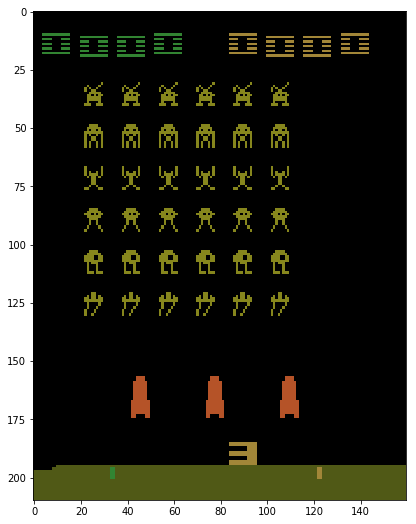

In [2]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('SpaceInvaders-v0')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

printing the observation space and action space's type.

In [3]:
print ('observation type :', env.observation_space)
print ('actions type :', env.action_space)

('observation type :', Box(210, 160, 3))
('actions type :', Discrete(6))


In [0]:
from __future__ import division
from __future__ import print_function

Observations are rgb images and actions are 6 discrete actions.
We plan to train the agent to play space invaders starting from scratch using policy gradient method. 
We choose the state value function as baseline 
we plan to tra


In [0]:
import numpy as np
import torch
import torch .nn as nn 
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as Optimizer

In DQN we have network to approximate Q function. We train the network using the regression loss MSE that is actually the difference in the approximated Q value and the expected Q value after rolling in one step in time shown as below

The orginal Q learning TD  update under tablualr Q learning is given as 

>$Q(s_t,a_t) = Q(s_t,a_t) + \alpha *(r + max_{a_{t+1}}Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))$

The gradient update for Q function under function approximation is 

>$\theta \leftarrow \theta - del_{\theta} \frac{1}{2}(r + max_{a_{t+1}}Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))^2$

\*\* Note\*\* : The final layer of the Q function should be linear for convergence

In [0]:
#training parameters 
batch_size = 16
n_episodes = 1000
replay_buffer_size = 1000
learning_rate = 1e-3
initial_e = 1
exploration_decay = 0.9
gamma = 0.9

In [0]:
# class Agent(object):
#   def __init__(self, _Q_network, initial_e, exploration_decay):
#     self.replay_buffer = list([])
#     self.policy = _Q_network
# #     self.exploration = initial_e
# #     self.exploration_decay = exploration_decay
 
#   def get_action(obs):
#     return np.argmax(_Q_network(obs))
 

In [0]:
class Q_network(nn.Module):
  def __init__(self):
    super(Q_network, self).__init__()
    self.block1 = nn.Sequential(
                    nn.Conv2d(3,16,4,stride=2,padding=0),
                    nn.BatchNorm2d(16))
    self.block2 = nn.Sequential(
                    nn.Conv2d(16,32,3,stride=2,padding=0),
                    nn.BatchNorm2d(32))
    self.block3 = nn.Sequential(
                    nn.Conv2d(32,64,3,stride=2,padding=0),
                    nn.BatchNorm2d(64))
    self.Linear1 = nn.Linear(26752 , 1024)
    self.Linear2 = nn.Linear(1024, 6)
    
  def forward(self, x, batch_size):
    input = x
    input = F.relu(self.block1(input))
    input = F.relu(self.block2(input))
    input = F.relu(self.block3(input))
    input = input.view(batch_size, -1)
    input = self.Linear1(input).clamp(min=0)
    return self.Linear2(input)


In [11]:

action_value_fn = Q_network()
loss = nn.MSELoss(reduction='sum')
optimizer = Optimizer.SGD(action_value_fn.parameters(), lr=1e-4, momentum=0.9)


dtype = torch.float
device = torch.device('cuda:0')
#initlializing replay buffer 
agent_experience = list([])
train = True


max_steps = 200
average_return = []
#training the network 
for i in range(n_episodes):
  state = torch.tensor(np.rollaxis(np.array([env.reset()[26:,:,:]])/255, 3, 1), device=device, dtype=dtype, requires_grad=False)
#   img = plt.imshow(env.render(mode='rgb_array'))
  total_reward = 0
  for step in range(max_steps):
    action_value_fn.cuda()
    action = np.random.randint(0,6) 
    
    #toss a coin to decide whether to explore or exploit
    if np.random.rand(0,1) > initial_e:
      action = torch.argmax(action_value_fn(state, 1)[0]).item()
      
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    
    next_state, reward, done, _ = env.step(action)
    
    next_state = torch.tensor(np.rollaxis(np.array([next_state[26:,:,:]]) /255, 3, 1), device=device, dtype=dtype, requires_grad=False)
    total_reward += reward
    agent_experience.append([state, action, reward, next_state])
    state = next_state
    
    if len(agent_experience) > replay_buffer_size:
      agent_experience = agent_experience[1:]
      if train == True:
        sampled_indices = np.random.randint(0, replay_buffer_size, batch_size)
        true_y = [agent_experience[ind][2] + gamma*torch.max(action_value_fn(agent_experience[ind][3], 1)).item() for 
                          ind in sampled_indices]
        pred_y = [action_value_fn(agent_experience[ind][0], 1)[0][agent_experience[ind][1]] for 
                         ind in sampled_indices]
        pred_y = torch.tensor(pred_y, device=device, requires_grad=True)
        true_y = torch.tensor(true_y, device=device)
        loss_ = loss(pred_y, true_y)
        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()
    
    if done: break
  print('Average episodic return : {}'.format(total_reward / (step + 1e-6)))
        
  average_return.append(total_reward / (step + 1e-6))
  initial_e *= exploration_decay
  
  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Average episodic return : 0.0753768840433
Average episodic return : 0.201005024116
Average episodic return : 0.376884420217
Average episodic return : 0.527638188303
Average episodic return : 0.251256280144
Average episodic return : 0.175879396101
Average episodic return : 0.276381908159
Average episodic return : 0.0251256280144
Average episodic return : 0.125628140072
Average episodic return : 0.0753768840433
Average episodic return : 0.150753768087
Average episodic return : 0.326633164188
Average episodic return : 0.251256280144
Average episodic return : 0.0753768840433
Average episodic return : 0.276381908159
Average episodic return : 0.0251256280144
Average episodic return : 0.0
Average episodic return : 0.0
Average episodic return : 0.0251256280144
Average episodic return : 0.100502512058
Average episodic return : 0.276381908159
Average episodic return : 0.150753768087
Average episodic return : 0.0251256280144
Average episodic return : 0.251256280144
Average episodic return : 0.226